#### Problem Statement
Banks face significant challenges in retaining their customers, as customer churn directly impacts profitability and operational efficiency. Customer churn in the banking sector occurs when customers close their accounts or switch to competitors, often due to dissatisfaction with services, lack of engagement, or more attractive offerings elsewhere.

The objective of this project is to analyze and predict customer churn for a bank using historical data. The dataset includes features such as customer demographics, account balance, credit score, tenure with the bank, and usage patterns of banking services.

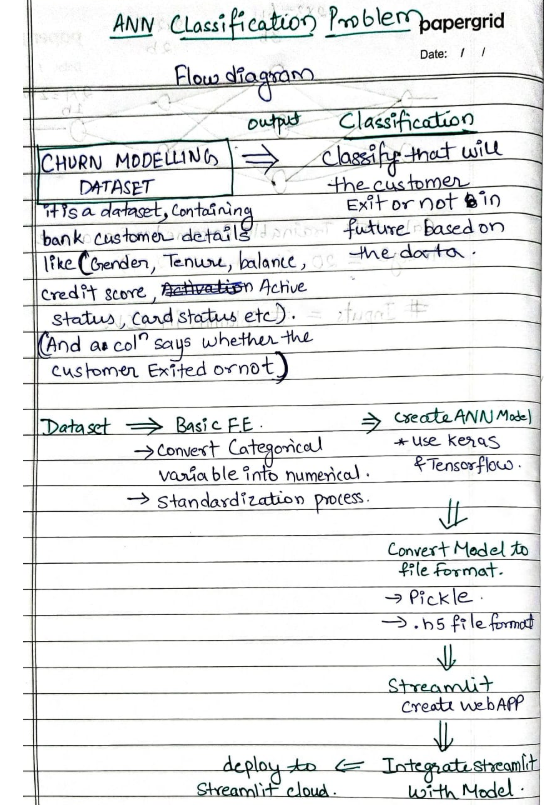

### Step1: Preprocessing of dataset

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pickle

In [5]:
df=pd.read_csv('../Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


remove the unnecessary columns 

In [6]:
df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


changing the text columns to numerical data for gender 

#### Why can't use label encoding for Geography?
We cannot use Label Encoding for features like "Geography" because it assigns numerical integers directly to each category. For example, it might assign 0 to "France," 1 to "Italy," and 2 to "Germany." Since Artificial Neural Networks (ANNs) operate on numerical values, they may mistakenly interpret these numbers as indicating an order or importance (e.g., "Germany" > "Italy" > "France"). This interpretation is incorrect, as these categories are not having any ranking.

To avoid this issue and ensure that each category is treated equally, we use One-Hot Encoding.

In [7]:
labelencoder=LabelEncoder()
df['Gender']=labelencoder.fit_transform(df['Gender'])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


The double brackets [['Geography']] are used to return a DataFrame with that single column, rather than a Series.

In [8]:
onehotencoder=OneHotEncoder()
geo_encoder=onehotencoder.fit_transform(df[['Geography']])
geo_encoder

<10000x3 sparse matrix of type '<class 'numpy.float64'>'
	with 10000 stored elements in Compressed Sparse Row format>

##### Problem
- The output of OneHotEncoder.fit_transform() is a sparse matrix (by default).
- When you try to create a Pandas DataFrame directly from this sparse matrix: Pandas will not interpret the sparse matrix properly, and it assumes there is only 1 column, causing error: ValueError: Shape of passed values is (10000, 1), indices imply (10000, 3)

##### Solution:
- Convert to numpy array
- Pandas automatically understands the shape of the NumPy array and creates a DataFrame where each row corresponds to a row in the NumPy array, and each column corresponds to a column in the array.

In [9]:
geo_encoder=geo_encoder.toarray()
onehotencoder.get_feature_names_out(['Geography'])

array(['Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype=object)

In [10]:
df_geo=pd.DataFrame(geo_encoder,columns=onehotencoder.get_feature_names_out(['Geography']))
df_geo.head()

,Geography_France,Geography_Germany,Geography_Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


removing the old geography column and combining the geo df with original df

In [11]:
df=pd.concat([df.drop(['Geography'],axis=1),df_geo],axis=1)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


### Step2: Store the data in pickle file and segregating data

In [12]:
with open('labelencoder.pkl','wb') as file:
    pickle.dump(labelencoder,file)

with open('onehotencoder.pkl','wb') as file:
    pickle.dump(onehotencoder,file)

In [13]:
X=df.drop(['Exited'],axis=1)
Y=df['Exited']

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

### Step3: Scaling data
#### What Does Scaling Do?
Imagine you are comparing apples and oranges:

Apples weigh in grams (e.g., 200 grams each). Oranges are priced in dollars (e.g., $2 each). If you give both these features (weight and price) to a machine learning algorithm without scaling, it might think that weight is more important just because the numbers (200) are bigger than price numbers (2). This could confuse the algorithm and make it focus on the wrong thing.

Scaling makes the features balanced, so they are treated equally. After scaling:

The weight of apples becomes something like 0.5. The price of oranges becomes something like 0.1. Now, they are on the same scale, and the algorithm can compare them fairly.

In [15]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [16]:
with open('scaler.pkl','wb') as file:
    pickle.dump(scaler,file)

### ANN Implementation
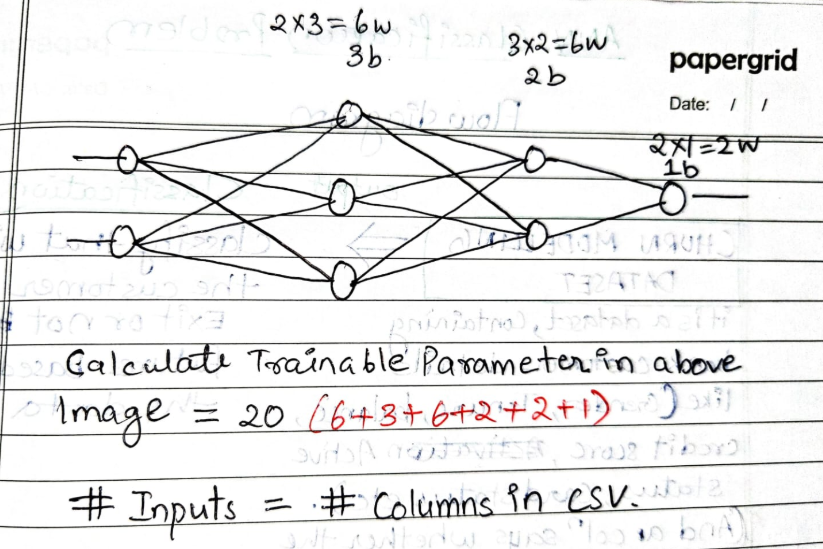

##### Steps Involve in Implementing/Training ANN Model:
1. Select model here we are going to use Sequential Model : It's designed for linear stacks of layers.
    - Sequential Model Characteristics:
        - Model Level:
            - A Sequential model accepts one input tensor for the entire model.
            - It produces one output tensor.
            - Data flows through the layers in a linear, ordered sequence without branching or merging.
        - Layer Level:
            - Each layer in the Sequential model takes the output of the previous layer as its input.
            - Each layer produces a single output tensor, which is then passed to the next layer.
    - A Sequential model is not appropriate when:
        - Your model has multiple inputs or multiple outputs
        - Any of your layers has multiple inputs or multiple outputs
2. Set Dense class: It is used to define Hidden layer. It's value represent no of neuron in hidden layer.
3. Set Activation parameter in Dense class: Define activation function.
    - And for first Dence layer it is **important to define Input(Shape)**
4. Set Optimizer.
5. Set loss function.
6. Set Metrics: Metrics are evaluation functions used to measure the performance of your model during training and testing
    - Classification Metrics:
        - accuracy.
        - binary_accuracy: For binary classification tasks.
        - categorical_accuracy: For multi-class classification with one-hot encoded labels.
        - sparse_categorical_accuracy: For multi-class classification with integer labels.
    - Regression Metrics:
        - mean_absolute_error (MAE).
        - mean_squared_error (MSE).
    - Specialized Metrics:
        - AUC
        - Precision: Fraction of true positives among predicted positives.
        - Recall: Fraction of true positives among actual positives.
7. Set Tensorboard: When we train the model we store the logs in a specified folder/directory. then use Tensorborad to visualize the logs as a graph. TensorBoard is a visualization tool used to monitor and debug TensorFlow models. It also stores logs in specified directory.

In [17]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime

Define model (Sequential model), dense layer, Activation function, input shape for 1st dense layer

In [18]:
(X_train.shape[1],) # 0 row 1 column
# Here 1st entry in tuple is Total no of inputs and 2nd entry is dimension of inputs. Empty means 1D(single value) inputs.

(12,)

In [ ]:
model=Sequential([
    # Dense(64,activation='relu',input_shape=(X_train.shape[1],))  # define input layer connect to HL1 together
    Input(shape=(X_train.shape[1],)),  # define input layer
    Dense(64,activation='relu'),  # HL1 connected to input layer
    Dense(32,activation='relu'),  # HL2 
    Dense(1,activation='sigmoid')  # output layer
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

Compile the model after defining loss function, Optimizer, metrics
- 2 Ways to define loss function and Optimizer.
    - Define the name directly during compiling. Here, the default learning rate is used.
    - Define it using the Keras function, assign it to variables and use that variable during compiling. Here custom learning rate can be used.

In [20]:
opt=tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.BinaryCrossentropy()
opt, loss

(<keras.src.optimizers.adam.Adam at 0x22cd0b2eac0>,
 <LossFunctionWrapper(<function binary_crossentropy at 0x0000022CCB9A7B80>, kwargs={'from_logits': False, 'label_smoothing': 0.0, 'axis': -1})>)

In [21]:
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
model

<Sequential name=sequential, built=True>

Setting up log directory, EarlyStopping, TensorBoard

In [22]:
#log directory
log_dir = 'log/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  #fit is just a convention showing training logs are stored.
#datetime is used to ensure each folder has unique name


# histogram_freq
# parameter specifies how frequently the histograms of weights and biases will be computed and stored.
# histogram_freq=1 means that the histograms will be logged after each epoch. 
# By default, histogram_freq is set to 0, which means histograms won't be saved.
# Allow you to log weight and bias in a histogram format.

tensorboard_callback = TensorBoard(log_dir= log_dir, histogram_freq=1)

### EarlyStopping
EarlyStopping is a callback in Keras used to stop training the model when a monitored metric (e.g., loss or accuracy) stops improving for a specified number of epochs or when the model has already converged. This helps to prevent overfitting and saves computational resources.

- parameter
    - monitor='val_loss': This specifies the metric to monitor for early stopping.
    - patience=10: sets the number of epochs to wait without improvement in the monitored metric (val_loss) before stopping the training.
    - restore_best_weights=True: This ensures that the model's weights are restored to the best weights when the training is stopped early.

In [23]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Train the model, Save the model in pickle or .h5 file
- .h5 file is similar to pickle file. it support keras that is why using it instead of .pkl file

In [24]:
history = model.fit(
    X_train,y_train, validation_data=(X_test, y_test), epochs =100,
    callbacks=[tensorboard_callback, early_stopping_callback]
)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8104 - loss: 0.4466 - val_accuracy: 0.8575 - val_loss: 0.3491
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8529 - loss: 0.3551 - val_accuracy: 0.8600 - val_loss: 0.3403
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8601 - loss: 0.3480 - val_accuracy: 0.8585 - val_loss: 0.3452
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8674 - loss: 0.3267 - val_accuracy: 0.8565 - val_loss: 0.3427
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8607 - loss: 0.3388 - val_accuracy: 0.8560 - val_loss: 0.3462
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8664 - loss: 0.3339 - val_accuracy: 0.8540 - val_loss: 0.3436
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8643 - loss: 0.3301 - val_accuracy: 0.8530 - val_loss: 0.3428
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8664 - loss: 0.3366 - val_accu

In [25]:
model.save('model.h5')

**%load_ext tensorboard**

Used to load the TensorBoard extension. Once loaded, you can run TensorBoard directly within the notebook to visualize your training logs, such as loss, accuracy, and histograms.

**%tensorboard --logdir logs/fit**

This command is used to launch TensorBoard in a Jupyter notebook and visualize training logs.

In [26]:
%load_ext tensorboard

In [28]:
%tensorboard --logdir log/fit

Reusing TensorBoard on port 6006 (pid 2956), started 0:00:07 ago. (Use '!kill 2956' to kill it.)